# Import necessary libraries

In [1]:
import cv2
import math
import numpy as np
import pandas as pd
import seaborn as sns
from pathlib import Path
from functools import partial
from datetime import datetime as dt
from dateutil.relativedelta import relativedelta
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.efficientnet import EfficientNetB0
from tensorflow.keras.applications.efficientnet import preprocess_input as EFNetPreProcessInput

import matplotlib.pyplot as plt
%matplotlib inline

time_now = lambda hours=0: dt.now() + relativedelta(hours=hours) # Set local time

# Record running time of notebook
print(f"Notebook is running at: {time_now()}")
print(f"Current working path: {Path.cwd()}")
print(f"TensorFlow version: {tf.__version__}")


# def set_checkpoint(save_path='model_checkpoints/checkpoints_weights.h5'):
#     """
#     Set checkpoint path and callbacks

#     Args:
#       save_path: Path the checkpoint saved to.
#     Return
#       checkpoint callback (str)
#     """
#     # Create ModelCheckpoint callback -> only save weights
#     checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=save_path,
#                                                              monitor='val_accuracy',
#                                                              mode='max',
#                                                              save_best_only=True, # only save the best weights
#                                                              verbose=1)
    
#     return checkpoint_callback

Notebook is running at: 2024-10-10 01:26:44.635890
Current working path: C:\Users\User\Desktop\cat_dog_dataset
TensorFlow version: 2.5.0


# Data preprocessing class

In [2]:
def breed_count(df, title, col_name='CLASSNAME'):
    breed_count  = df[col_name].value_counts()

    plt.figure(figsize=(20,5))
    sns.barplot(x=breed_count.index, y=breed_count.values, alpha=0.8)
    plt.title('Value count of number of ' + title)
    plt.ylabel('Number of Occurrences', fontsize=12)
    plt.xlabel('Breed Names', fontsize=10)
    plt.xticks(rotation=90)
    plt.show()

In [3]:
class DataTransformer:
    def __init__(self, data_path:str):
        self.data_path = data_path
        
    def read_data(self) -> pd.DataFrame:
        """Read data via pandas module."""
        return pd.read_csv(self.data_path).loc[5:,]

    def preprocess(self) -> pd.DataFrame:
        """
        Preprocess data via following steps:
        1. Read data from a txt file of data_path, return a DataFrame.
        2. Process the columns via splitting operation.
        3. Drop unnecessary columns.
        4. Rename the columns to specific column names.
        5. Convert the object type to int type for further processing.
        6. Add suffix to the image columns with 'jpg' extension.
        7. Extract the classname/breed of the animal, create a new column for labels.

        Returns: DataFrame of preprocessed data.
        """
        df = self.read_data()
        df[['CLASS-ID','SPECIES','BREED','ID']] = df['#Image CLASS-ID SPECIES BREED ID'].str.split(expand=True) 
        df = df.drop('#Image CLASS-ID SPECIES BREED ID', axis=1)
        df = df.rename(columns={'CLASS-ID': 'IMAGE', 'SPECIES': 'CLASS_ID', 'BREED': 'SPECIES', 'ID': 'BREED_ID'})
        df[["CLASS_ID","SPECIES","BREED_ID"]] = df[["CLASS_ID","SPECIES","BREED_ID"]].astype(int)
        df['IMAGE'] = df['IMAGE'].apply(lambda x: str(x) + '.jpg')
        df = df.reset_index()
        df['CLASSNAME'] = df['IMAGE'].apply(lambda x: ' '.join(str(x).split('_')[:-1]))
        df = df.drop('index', axis=1)
        
        return df

In [4]:
ANNOTATION_DATA_PATH = './Cats_and_Dogs_Breeds_Classification_Oxford_Dataset/annotations/annotations/list.txt'

data_transformer = DataTransformer(ANNOTATION_DATA_PATH)
data_df = data_transformer.preprocess()
data_df

,IMAGE,CLASS_ID,SPECIES,BREED_ID,CLASSNAME
0,Abyssinian_100.jpg,1,1,1,Abyssinian
1,Abyssinian_101.jpg,1,1,1,Abyssinian
2,Abyssinian_102.jpg,1,1,1,Abyssinian
3,Abyssinian_103.jpg,1,1,1,Abyssinian
4,Abyssinian_104.jpg,1,1,1,Abyssinian
...,...,...,...,...,...
7344,yorkshire_terrier_96.jpg,37,2,25,yorkshire terrier
7345,yorkshire_terrier_97.jpg,37,2,25,yorkshire terrier
7346,yorkshire_terrier_98.jpg,37,2,25,yorkshire terrier
7347,yorkshire_terrier_99.jpg,37,2,25,yorkshire terrier


In [5]:
# df_cat = data_df[data_df['SPECIES'] == 1]
# df_cat_sample = df_cat.sample(frac=1)

# df_cat_sample

In [6]:
# breed_count(data_df[data_df.SPECIES == 1], 'ID', 'CLASSNAME')

# Data augmentation class

In [7]:
class DataAugmentation:
    def __init__(self, 
                 dataframe:pd.DataFrame, 
                 img_data_path:str, 
                 img_size:int=224, 
                 batch_size:int=32, 
                 preprocess_function=EFNetPreProcessInput):
        self.dataframe = dataframe
        self.DATA_PATH = img_data_path
        self.IMG_SIZE = img_size
        self.BATCH_SIZE = batch_size
        self.preprocess_function = preprocess_function
        self.IMG_SHAPE = (self.IMG_SIZE, self.IMG_SIZE)
        self.train_datagen, self.valid_datagen = self.data_generator()
        
    def data_generator(self):
        """Generate data via ImageDataGenerator object."""
        train_datagen = ImageDataGenerator(preprocessing_function=self.preprocess_function,
                                           shear_range=0.2,
                                           zoom_range=0.2,
                                           horizontal_flip=True,
                                           vertical_flip=True,
                                           validation_split=0.2,
                                           rotation_range=90,
                                           width_shift_range=0.2, 
                                           height_shift_range=0.2)
        
        valid_datagen = ImageDataGenerator(preprocessing_function=self.preprocess_function, 
                                           validation_split=0.2)

        return (train_datagen, valid_datagen)

    def create_flow(self):
        """Create flow data of data generator."""
        self.train_gen_flow = self.train_datagen.flow_from_dataframe(dataframe=self.dataframe,
                                                                     directory=self.DATA_PATH,
                                                                     x_col='IMAGE',
                                                                     y_col='CLASSNAME',
                                                                     target_size=self.IMG_SHAPE,
                                                                     batch_size=self.BATCH_SIZE,
                                                                     class_mode="categorical",
                                                                     subset='training',
                                                                     shuffle=True)
    
        self.valid_gen_flow = self.valid_datagen.flow_from_dataframe(dataframe=self.dataframe,
                                                                     directory=self.DATA_PATH,
                                                                     x_col='IMAGE',
                                                                     y_col='CLASSNAME',
                                                                     target_size=self.IMG_SHAPE,
                                                                     batch_size=self.BATCH_SIZE,
                                                                     class_mode="categorical",
                                                                     subset='validation', 
                                                                     shuffle=False)
        return (self.train_gen_flow, self.valid_gen_flow)

In [8]:
# DATA_PATH = './Cats_and_Dogs_Breeds_Classification_Oxford_Dataset/images/images'
# IMG_SIZE = 224
# BATCH_SIZE = 32

# # Separate cats and dogs
# df_cat = data_df[data_df['SPECIES']==1] # cat : 1
# df_dog = data_df[data_df['SPECIES']==2] # dog : 2

# cat_data_aug = DataAugmentation(dataframe=df_cat, 
#                                 img_data_path=DATA_PATH, 
#                                 img_size=IMG_SIZE, 
#                                 batch_size=BATCH_SIZE, 
#                                 preprocess_function=EFNetPreProcessInput)

# train_data_gen_cat, valid_data_gen_cat = cat_data_aug.create_flow()

# train_data_gen_cat.class_indices

# Animal classifier class

In [9]:
class AnimalClassifier:
    def __init__(self, base_model, input_shape, output_shape, epochs=5, Init_lr=1e-3,
                 fine_tune_ratio=None, fine_tune_epochs=3, lr_decay_type:str=''):
        """
        Args:
          base_model: Transfer learning model passed into building structure.
          input_shape: Input shape for the transfer model.
          output_shape: Output shape for the transfer model.
          epochs: Epochs for model training.
          fine_tune_ratio: Ratio for trainable layers of base model.
          fine_tune_epochs: Epochs for model fine-tuning.
          lr_decay_type: Type of learning rate decay
        """
        self.base_model       = base_model
        self.input_shape      = input_shape
        self.output_shape     = output_shape
        self.epochs           = epochs
        self.fine_tune_ratio  = fine_tune_ratio
        self.fine_tune_epochs = fine_tune_epochs
        self.Epoch            = self.epochs + self.fine_tune_epochs

        # ----------------------------
        # Model optimization
        # 1. learning rate scheduler
        # 2. learning rate decay
        # ----------------------------
        self.Init_lr           = Init_lr
        self.Adam              = tf.keras.optimizers.Adam
        self.compile_model     = lambda model, lr=self.Init_lr: model.compile(loss='categorical_crossentropy', 
                                                                              optimizer=self.Adam(learning_rate=lr), 
                                                                              metrics=['accuracy'])
        if lr_decay_type:
            self.lr_decay_type = lr_decay_type
            self.Min_lr        = self.Init_lr * 0.001
            self.lr_func       = self.get_lr_scheduler(lr_decay_type=self.lr_decay_type, 
                                                       lr=self.Init_lr, 
                                                       min_lr=self.Min_lr, 
                                                       total_iters=self.Epoch)
            self.lr_scheduler  = tf.keras.callbacks.LearningRateScheduler(self.lr_func, verbose=1)
            self.callbacks     = [self.lr_scheduler]
        else:
            self.reduce_lr     = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.8, patience=1, 
                                                                      verbose=2, min_lr=self.Init_lr * 0.0001, mode='min')
            self.callbacks     = [self.reduce_lr]
        
    def build_model(self):
        """Build a transfer learning model."""
        self.base_model.trainable = False
    
        inputs = tf.keras.layers.Input(shape=self.input_shape, name="input_layer")
        x = self.base_model(inputs, training=False)
        x = tf.keras.layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)
        outputs = tf.keras.layers.Dense(self.output_shape, activation="softmax", name="output_layer")(x)
        model = tf.keras.Model(inputs, outputs, name="animal_classifier")
    
        print(model.summary())
    
        return model

    def get_lr_scheduler(self, lr_decay_type:str, lr:float, min_lr:float, total_iters:int,
                         warmup_iters_ratio:float=0.1, warmup_lr_ratio:float=0.1, no_aug_iter_ratio:float=0.3, step_num:int=10):
        """
        Functions for learning rate decay, cosine or step decay.
    
        Args:
            lr_decay_type: Type of learning rate decay, cos or step
            lr: Learning rate
            min_lr: Minimum learning rate
            total_iters: Total iterations of training
            warmup_iters_ratio: Ratio for warm up iteration
            warmup_lr_ratio: Ratio for warm up learning rate
            no_aug_iter_ratio: Ratio for no augmentation iterations, this phase will maintain at minimum learning rate.
            step_num: Number of steps for step decay
        Returns:
            Function for learning rate decay.
        """
        def yolox_warm_cos_lr(lr, min_lr, total_iters, warmup_total_iters, warmup_lr_start, no_aug_iter, iters):
            if iters <= warmup_total_iters: # warm up iters
                lr = (lr - warmup_lr_start) * pow(iters / float(warmup_total_iters), 2) + warmup_lr_start
            elif iters >= total_iters - no_aug_iter: # no augmentation iters, it will maintain at minimum iter
                lr = min_lr
            else: # learning rate decay
                lr = min_lr + 0.5 * \
                    (lr - min_lr) * \
                    (1.0 + math.cos(math.pi * (iters - warmup_total_iters) / (total_iters - warmup_total_iters - no_aug_iter)))
            return lr

        def step_lr(lr, decay_rate, step_size, iters):
            if step_size < 1:
                raise ValueError("step_size must above 1.")
            n       = iters // step_size # Number of steps
            out_lr  = lr * decay_rate ** n # learning rate decay
            return out_lr
        
        if lr_decay_type == "cos":
            warmup_total_iters  = min(max(warmup_iters_ratio * total_iters, 1), 3) # range [1, 3]
            warmup_lr_start     = max(warmup_lr_ratio * lr, 1e-3) # at least 1e-3
            no_aug_iter         = min(max(no_aug_iter_ratio * total_iters, 1), 3) # range [1, 5]
            func = partial(yolox_warm_cos_lr ,lr, min_lr, total_iters, warmup_total_iters, warmup_lr_start, no_aug_iter)
        else:
            decay_rate          = (min_lr / lr) ** (1 / (step_num - 1)) # decay rate
            step_size           = total_iters / step_num
            func                = partial(step_lr, lr, decay_rate, step_size)

        return func

    def train(self, train_data, valid_data):
        self.model = self.build_model()
        self.compile_model(self.model, lr=self.Init_lr)
        self.original_history = self.model.fit(train_data, 
                                               epochs=self.epochs,
                                               validation_data=valid_data,
                                               callbacks=[self.callbacks],
                                               initial_epoch=0)
        if self.fine_tune_ratio:
            self.fine_tune_model_layers()
            self.compile_model(self.model, lr=self.Init_lr * 0.1)
            self.new_history = self.model.fit(train_data, 
                                              epochs=self.epochs+self.fine_tune_epochs,
                                              validation_data=valid_data,
                                              callbacks=[self.callbacks],
                                              initial_epoch=self.epochs)
            self.compare_historys()
        else: 
            self.plot_loss_curves()

    def fine_tune_model_layers(self):
        """Set specific layers being trainable for further model training."""
        fine_tune_base_model = self.model.layers[1]
        layer_number = -int(len(fine_tune_base_model.layers) * self.fine_tune_ratio)
    
        # Unfreeze all of the layers in the base model
        fine_tune_base_model.trainable = True
    
        # Refreeze every layer except for the last 5
        for layer in fine_tune_base_model.layers[:layer_number]:
            layer.trainable = False
    
        print(f"Change last {-layer_number} layers of {fine_tune_base_model.name} successfully, please recompile model again.")
    
    def plot_loss_curves(self):
        """Returns separate loss curves for training and validation metrics."""
        # Get original history
        history = self.original_history.history
        
        # losses and accuracy
        loss = history["loss"]
        val_loss = history["val_loss"]
        accuracy = history["accuracy"]
        val_accuracy = history["val_accuracy"]
    
        # epochs
        epochs = range(1, len(history["loss"])+1)
    
        # plot loss and accuracy
        plt.figure(figsize=(12, 6))
        plt.subplot(1,2,1)
        plt.plot(epochs, loss, label="training_loss")
        plt.plot(epochs, val_loss, label="val_loss")
        plt.title("Loss")
        plt.xlabel("Epochs")
        plt.legend()
    
        plt.subplot(1,2,2)
        plt.plot(epochs, accuracy, label="training_accuracy")
        plt.plot(epochs, val_accuracy, label="val_accuracy")
        plt.title("Accuracy")
        plt.xlabel("Epochs")
        plt.legend();

    def compare_historys(self):
        """Compares two TensorFlow model History objects."""
        # Get history and epochs
        original_history = self.original_history.history
        new_history = self.new_history.history
        initial_epochs = self.epochs+1
        epochs = range(1, initial_epochs+self.fine_tune_epochs)
        
        # Get original history measurements
        acc = original_history["accuracy"]
        loss = original_history["loss"]
    
        val_acc = original_history["val_accuracy"]
        val_loss = original_history["val_loss"]
    
        # Combine original history with new history
        total_acc = acc + new_history["accuracy"]
        total_loss = loss + new_history["loss"]
    
        total_val_acc = val_acc + new_history["val_accuracy"]
        total_val_loss = val_loss + new_history["val_loss"]
    
        # Make plots
        plt.figure(figsize=(8, 8))
        plt.subplot(2,1,1)
        plt.plot(epochs, total_acc, label='Training Accuracy')
        plt.plot(epochs, total_val_acc, label='Validation Accuracy')
        plt.plot([initial_epochs, initial_epochs], plt.ylim(), label='Model Freeze') # shift plot around epochs
        plt.legend(loc='lower right')
        plt.title('Training and Validation Accuracy')
    
        plt.subplot(2,1,2)
        plt.plot(epochs, total_loss, label='Training Loss')
        plt.plot(epochs, total_val_loss, label='Validation Loss')
        plt.plot([initial_epochs, initial_epochs], plt.ylim(), label='Model Freeze') # shift plot around epochs
        plt.legend(loc='upper right')
        plt.title('Training and Validation Loss')
        plt.xlabel('epoch')
        plt.show()

# Classifier training

Found 1897 validated image filenames belonging to 12 classes.
Found 474 validated image filenames belonging to 12 classes.
Model: "animal_classifier"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 224, 224, 3)]     0         
_________________________________________________________________
efficientnetb0 (Functional)  (None, None, None, 1280)  4049571   
_________________________________________________________________
global_average_pooling_layer (None, 1280)              0         
_________________________________________________________________
output_layer (Dense)         (None, 12)                15372     
Total params: 4,064,943
Trainable params: 15,372
Non-trainable params: 4,049,571
_________________________________________________________________
None
Epoch 1/5

Epoch 00001: LearningRateScheduler reducing learning rate to 0.001.
60/60 [==================

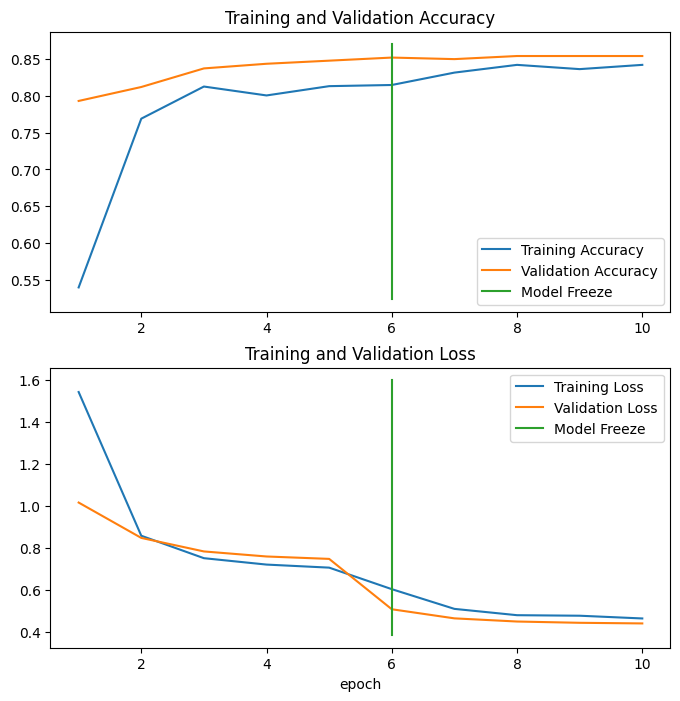

c:\Users\User\miniconda3\envs\cat_dog_project\lib\site-packages\tensorflow\python\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Accuracy score on testing dataset: 0.8277512192726135


In [8]:
# Set random seed and clear session
seed = 42
np.random.seed(seed)
tf.random.set_seed(seed)
tf.keras.backend.clear_session()
ANNOTATION_PATH = './Cats_and_Dogs_Breeds_Classification_Oxford_Dataset/annotations/annotations/list.txt'
IMG_SIZE = 224
INPUT_SHAPE = (IMG_SIZE, IMG_SIZE, 3)
BATCH_SIZE = 32
DATA_PATH = './Cats_and_Dogs_Breeds_Classification_Oxford_Dataset/images/images'


def get_classes(class_indices:dict, save_path='') -> list:
    """
    Get animal classes from class indices of dictionary.

    Args:
        class_indices: Class indices in dictionary data type.
    Returns: 
        Class names in list data type.
    """
    pairs = [(cls_name, index) for cls_name, index in class_indices.items()] # convert to list with tuple
    pairs_sorted = sorted(pairs, key=lambda pairs: pairs[1]) # sorting values
    classes = np.array([pair_cls[0] for pair_cls in pairs_sorted]) # convert to numpy array
    if save_path: np.save(save_path, classes) # save labels

    return classes


def preprocess_image(image_path:str, size:tuple=(IMG_SIZE, IMG_SIZE)) -> np.array:
    """
    Preprocess images by following steps:
    1. read image
    2. convert image into RGB channel (OpenCV default BGR)
    3. resize image to size+(3,)
    4. preprocess image by efficientNet preprocess input

    Args:
        image_path: Image path for preprocessing
        size: image size for resizing
    Returns:
        Processed images in numpy array data type
    """
    image = cv2.imread(image_path)
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    resized_image = cv2.resize(image_rgb, size)
    final_image = EFNetPreProcessInput(resized_image)
    
    return final_image

def create_dataset(images:np.array, batch_size:int=32) -> tf.data.Dataset:
    """Create dataset from images."""
    # generate image dataset
    image_ds = tf.data.Dataset.from_tensor_slices(tf.constant(images))
    
    # convert image dataset to 32 batch size
    image_ds = image_ds.batch(batch_size)
    image_ds = image_ds.prefetch(buffer_size=tf.data.AUTOTUNE)  # prefetch data for higher efficiency
    
    return image_ds

def calculate_accuracy(y_true:tf.Tensor, y_pred:tf.Tensor) -> np.float32:
    """
    Create accuracy score via true labels and model predictions.

    Args:
        y_true: True labels from dataset
        y_pred: Model predictions
    Returns:
        Accuracy score
    """
    results = tf.equal(tf.argmax(y_pred, axis=1), tf.argmax(y_true, axis=1))
    results_to_float = tf.cast(results, tf.float32)
    accuracy_score = tf.reduce_mean(results_to_float).numpy()

    return accuracy_score

def evaluate(class_indices:dict, real_classes:list, species_path:str, model:tf.keras.Model) -> float:
    """
    Evaluate model performance from test images collected before.

    Ags:
        class_indices: Dictionary of class names and class indices
        real_classes: List of real classes
        species_path: Test images path
        model: Model for evaluation
    Returns:
        Accuracy score in float data type
    """
    # Prepare testing images and labels
    test_image_and_paths = [(img_path, class_indices[cls]) for cls in real_classes \
                                                           for img_path in Path(species_path).joinpath(cls).glob('*')]
    image_paths, labels = zip(*test_image_and_paths) # separate images and labels
    test_images = [preprocess_image(str(img_path), size=(IMG_SIZE, IMG_SIZE)) for img_path in image_paths] # prepare test images
    test_labels = tf.one_hot(labels, depth=len(np.unique(np.array(labels)))) # prepare test labels with one hot encoding
    test_dataset = create_dataset(test_images, batch_size=BATCH_SIZE) # create testing dataset by tensorflow
    y_preds = model.predict(test_dataset)
    Acc_Score = calculate_accuracy(test_labels, y_preds)

    return Acc_Score

def train_classifier(species:str='', save_model=False) -> AnimalClassifier:
    # Data preprocessing
    data_transformer = DataTransformer(ANNOTATION_PATH)
    data_df = data_transformer.preprocess()

    # Data augmentation
    if species.lower() == 'cats':
        df_species = data_df[data_df['SPECIES']==1] # cat : 1 --> epochs: 5, fine_tune_ratio=0.15, fine_tune_epochs=5
        params = {'epochs': 5, 'fine_tune_ratio': 0.15, 'fine_tune_epochs': 5, 'lr_decay_type': 'step'}
    elif species.lower() == 'dogs':
        df_species = data_df[data_df['SPECIES']==2] # dog : 2 --> epochs: 10, fine_tune_ratio=None, fine_tune_epochs=0
        params = {'epochs': 10, 'fine_tune_ratio': None, 'fine_tune_epochs': 0, 'lr_decay_type': None}
    else: raise ValueError('cats or dogs only !')
    
    data_aug = DataAugmentation(dataframe=df_species,
                                img_data_path=DATA_PATH, 
                                img_size=IMG_SIZE, 
                                batch_size=BATCH_SIZE, 
                                preprocess_function=EFNetPreProcessInput)
    train_data_gen, valid_data_gen = data_aug.create_flow()

    # prepare label classes
    class_indices = train_data_gen.class_indices
    real_classes = get_classes(class_indices, save_path='%s_classes.npy'%(species))
    
    # Model training
    base_model = EfficientNetB0(include_top=False)
    breed_classifier = AnimalClassifier(base_model,  
                                        input_shape=INPUT_SHAPE, 
                                        output_shape=len(real_classes), 
                                        epochs=params['epochs'], 
                                        Init_lr=1e-3,
                                        fine_tune_ratio=params['fine_tune_ratio'], 
                                        fine_tune_epochs=params['fine_tune_epochs'], 
                                        lr_decay_type=params['lr_decay_type'])
    breed_classifier.train(train_data_gen, valid_data_gen)

    # Model saving
    if save_model: breed_classifier.model.save('%s_classifier.h5'%(species))

    # Model evaluation
    species_path = './test_images/%s' % (species)
    acc_score = evaluate(class_indices, real_classes, species_path, breed_classifier.model)
    print(f"Accuracy score on testing dataset: {acc_score}")

    return breed_classifier

# dogs_classifier = train_classifier('dogs', save_model=True)
cats_classifier = train_classifier('cats', save_model=True)

# Predict one image

## Evaluation

In [21]:
ANNOTATION_DATA_PATH = './Cats_and_Dogs_Breeds_Classification_Oxford_Dataset/annotations/annotations/list.txt'
data_transformer = DataTransformer(ANNOTATION_DATA_PATH)
data_df = data_transformer.preprocess()
DATA_PATH = './Cats_and_Dogs_Breeds_Classification_Oxford_Dataset/images/images'
IMG_SIZE = 224
BATCH_SIZE = 32

# Separate cats and dogs
df_cat = data_df[data_df['SPECIES']==1] # cat
cat_data_aug = DataAugmentation(dataframe=df_cat, 
                                img_data_path=DATA_PATH, 
                                img_size=IMG_SIZE, 
                                batch_size=BATCH_SIZE, 
                                preprocess_function=EFNetPreProcessInput)

train_data_gen_cat, valid_data_gen_cat = cat_data_aug.create_flow()
cats_indices = train_data_gen_cat.class_indices # class_indices
species_path = './test_images/cats' # species path
cats_real_classes = np.load('cats_classes.npy') # real classes
cats_classifier_loaded = tf.keras.models.load_model('./cats_classifier.h5') # classifier model

Found 1897 validated image filenames belonging to 12 classes.
Found 474 validated image filenames belonging to 12 classes.


In [22]:
evaluate(cats_indices, cats_real_classes, species_path, cats_classifier_loaded)

0.8229665

## Prediction: Prepare test images

Image array shape: (183, 275, 3)
Image array dtype: uint8


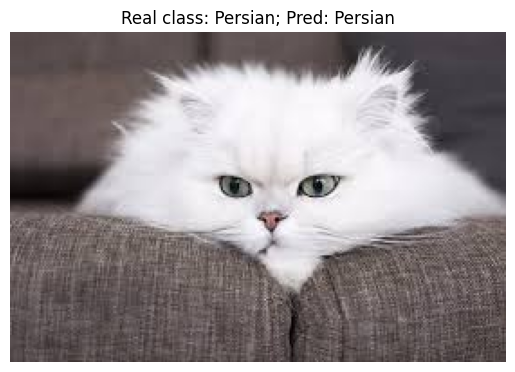

In [69]:
import base64
import random
from io import BytesIO
from PIL import Image
import numpy as np

# Prepare testing images and labels
cats_real_classes = np.load('cats_classes.npy') # real classes
tets_dataset_path = Path('test_images').joinpath('cats')
real_cats_indices = {'Abyssinian': 0, 'Bengal': 1, 'Birman': 2, 'Bombay': 3,
                     'British Shorthair': 4, 'Egyptian Mau': 5, 'Maine Coon': 6,
                     'Persian': 7, 'Ragdoll': 8, 'Russian Blue': 9,
                     'Siamese': 10, 'Sphynx': 11}
test_image_and_paths = [(img_path, real_cats_indices[cls]) for cls in cats_real_classes \
                                                           for img_path in Path(tets_dataset_path).joinpath(cls).glob('*')]
image_paths, labels = zip(*test_image_and_paths) # separate images and labels

# Select random image
rand_idx = random.randint(0, len(image_paths)-1)
imgPath, imgClass = image_paths[rand_idx], labels[rand_idx]

# Compress the image and return the compressed base64 encoding
def compress_image_to_base64(input_image_path, quality=75):
    # Open the image using OpenCV
    img = cv2.imread(input_image_path)
    
    # Convert image from BGR to RGB (OpenCV uses BGR by default)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    # Convert the image to PIL format
    img_pil = Image.fromarray(img_rgb)

    # Use BytesIO to store the compressed image in memory
    buffered = BytesIO()
    
    # Compress the image and save it to the memory's BytesIO object instead of disk
    img_pil.save(buffered, format="JPEG", quality=quality)
    
    # Convert the compressed image data in BytesIO to base64
    img_base64 = base64.b64encode(buffered.getvalue()).decode("utf-8")
    
    return img_base64

# Convert the compressed image to Base64
base64_str = compress_image_to_base64(imgPath, quality=50)

# Display the Base64 result
print_Base64 = lambda base64_str: print(f"Base64 encoding of the image:\n{base64_str}")


# -------------------------------------------
# Convert a base64 encoded image to a NumPy array
def base64_to_array(base64_str):
    # Decode the base64 string back to bytes
    img_data = base64.b64decode(base64_str)
    
    # Use BytesIO to convert the decoded bytes to an image
    img = Image.open(BytesIO(img_data))
    
    # Convert the PIL image to a NumPy array
    img_array = np.array(img)
    
    return img_array

# Test converting Base64 encoded string back to an array
# Convert the base64 string to a NumPy array
img_array = base64_to_array(base64_str)

# Display the image's shape and data type
print("Image array shape:", img_array.shape)
print("Image array dtype:", img_array.dtype)

def Model_Predict(model, image_rgb, img_size=(224, 224)):
    # Image preprocessing
    image_rgb = image_rgb.astype(np.float32)
    resized_image = cv2.resize(image_rgb, img_size) # resize image to (224, 224, 3)
    processed_image = EFNetPreProcessInput(resized_image)  # preprocess image
    image_for_pred = np.expand_dims(processed_image, axis=0) # add a batch dim
    
    # Model prediction
    cats_real_classes = np.load('cats_classes.npy') # real classes
    model_pred = model.predict(image_for_pred) # predict image
    pred_index = np.argmax(np.squeeze(model_pred)) # get the highest class index
    final_class = cats_real_classes[pred_index] # final image class
    
    return final_class

final_class = Model_Predict(cats_classifier_loaded, img_array, img_size=(IMG_SIZE, IMG_SIZE))
plt.imshow(plt.imread(imgPath))
plt.title(f"Real class: {cats_real_classes[imgClass]}; Pred: {final_class}")
plt.axis('off')
plt.show()

# End